<a href="https://colab.research.google.com/github/Anshad-Aziz/Chatbot-Question-Validator-from-Story/blob/main/Chatbot_Question_Validator_from_Story.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import numpy as np
import keras
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM

In [2]:
with open("/content/train_qa.txt","rb") as fp:
  train_data=pickle.load(fp)
with open("/content/test_qa.txt","rb") as fp:
  test_data=pickle.load(fp)

In [3]:
display(train_data[:1])

[(['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.'],
  ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
  'no')]

In [4]:
display(test_data[:1])

[(['Mary',
   'got',
   'the',
   'milk',
   'there',
   '.',
   'John',
   'moved',
   'to',
   'the',
   'bedroom',
   '.'],
  ['Is', 'John', 'in', 'the', 'kitchen', '?'],
  'no')]

In [5]:
print("Type of train data: ",type(train_data))
print("length of training data:",len(train_data))

Type of train data:  <class 'list'>
length of training data: 10000


In [6]:
" ".join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [7]:
" ".join(train_data[0][1])

'Is Sandra in the hallway ?'

In [8]:
train_data[0][2]

'no'

In [9]:
vocab=set()

In [12]:
all_data=test_data+train_data

In [13]:
print("Type of all data:",type(all_data))
print("length of all data:",len(all_data))

Type of all data: <class 'list'>
length of all data: 20000


In [14]:
for story,question,qnswer in all_data:
  vocab=vocab.union(set(story))
  vocab=vocab.union(set(question))

In [15]:
vocab.add('yes')
vocab.add('no')

In [16]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [17]:
len(vocab)

37

In [18]:
vocab_len=len(vocab)+1
max_story_len=max([len(data[0])for data in all_data])
print("Maximum length of story ",max_story_len)

Maximum length of story  156


In [19]:
max_ques_len=max(len(data[1])for data in all_data)
print("maximum length of question ",max_ques_len)

maximum length of question  6


In [20]:
tokenizer=Tokenizer(filters=[])

In [21]:
tokenizer.fit_on_texts(vocab)

In [22]:
tokenizer.word_index

{'back': 1,
 'left': 2,
 'yes': 3,
 'football': 4,
 'the': 5,
 '?': 6,
 'no': 7,
 'daniel': 8,
 'journeyed': 9,
 'hallway': 10,
 'up': 11,
 'down': 12,
 'went': 13,
 'bedroom': 14,
 'kitchen': 15,
 'travelled': 16,
 'in': 17,
 'to': 18,
 'took': 19,
 'got': 20,
 'grabbed': 21,
 'john': 22,
 'sandra': 23,
 'apple': 24,
 'moved': 25,
 'milk': 26,
 'mary': 27,
 'picked': 28,
 'is': 29,
 'office': 30,
 'dropped': 31,
 'put': 32,
 'there': 33,
 'discarded': 34,
 '.': 35,
 'garden': 36,
 'bathroom': 37}

In [23]:
train_story_text=[]
train_question_text=[]
train_answer=[]
for story,question,answer in train_data:
  train_story_text.append(story)
  train_question_text.append(question)

In [24]:
train_story_seq=tokenizer.texts_to_sequences(train_story_text)

In [25]:
train_story_seq[0]

[27, 25, 18, 5, 37, 35, 23, 9, 18, 5, 14, 35]

In [27]:
train_story_text[0]

['Mary',
 'moved',
 'to',
 'the',
 'bathroom',
 '.',
 'Sandra',
 'journeyed',
 'to',
 'the',
 'bedroom',
 '.']

In [28]:
#function for vectorizing story from data
def vectorize_stories(data,word_index =tokenizer.word_index,
                     max_story_len=max_story_len,max_ques_len=max_ques_len):
    X=[] #stroies
    Xq=[] #question
    Y=[] #correct answers

    for story,query,answer in data:
        x=[word_index[word.lower()] for word in story]
        xq=[word_index[word.lower()] for word in query]
        y=np.zeros(len(word_index)+1)
        y[word_index[answer]]=1

        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return(pad_sequences(X,maxlen=max_story_len),
          pad_sequences(Xq,maxlen=max_ques_len),
          np.array(Y))


In [29]:
inputs_train,queries_train,answers_train=vectorize_stories(train_data)

In [30]:
inputs_test,queries_test,answers_test=vectorize_stories(test_data)

In [31]:
inputs_train

array([[ 0,  0,  0, ...,  5, 14, 35],
       [ 0,  0,  0, ...,  5, 10, 35],
       [ 0,  0,  0, ...,  5, 37, 35],
       ...,
       [ 0,  0,  0, ...,  5, 14, 35],
       [ 0,  0,  0, ..., 26, 33, 35],
       [ 0,  0,  0, ..., 24, 33, 35]], dtype=int32)

In [32]:
queries_test

array([[29, 23, 17,  5, 10,  6],
       [29,  8, 17,  5, 37,  6],
       [29,  8, 17,  5, 30,  6],
       ...,
       [29, 23, 17,  5, 10,  6],
       [29, 27, 17,  5, 15,  6],
       [29, 27, 17,  5, 14,  6]], dtype=int32)

In [34]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
tokenizer.word_index["yes"]

3

In [36]:
tokenizer.word_index['no']

7

In [43]:
input_sequence=Input((max_story_len,))
question=Input((max_ques_len,))

In [38]:
input_encoder_m=Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len,output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [40]:
input_encoder_c=Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len,output_dim=max_ques_len))
input_encoder_c.add(Dropout(0.3))

In [41]:
question_encoder=Sequential()
question_encoder.add(Embedding(input_dim=vocab_len,output_dim=64,input_length=max_ques_len))
question_encoder.add(Dropout(0.3))

In [44]:
input_encoded_m=input_encoder_m(input_sequence)
input_encoded_c=input_encoder_c(input_sequence)
question_encoded=question_encoder(question)

In [45]:
match=dot([input_encoded_m,question_encoded],axes=(2,2))
match= Activation("softmax")(match)

In [46]:
response=add([match,input_encoded_c])
response=Permute((2,1))(response)

In [47]:
answer =concatenate([response,question_encoded])
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [48]:
answer=LSTM(32)(answer)

In [49]:
answer=Dropout(0.5)(answer)
answer=Dense(vocab_len)(answer)

In [50]:
answer=Activation("softmax")(answer)

In [51]:
model=Model([input_sequence,question],answer)
model.compile(optimizer="rmsprop",loss='categorical_crossentropy',metrics=['accuracy'])


In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 156)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 64)             2432      ['input_3[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 6, 64)                2432      ['input_4[0][0]']             
                                                                                              

In [53]:
history=model.fit([inputs_train,queries_train],answers_train,batch_size=32,epochs=20,validation_data=([inputs_test,queries_test],answers_test))

Epoch 1/20
313/313 [==============================] - 7s 16ms/step - loss: 0.8959 - accuracy: 0.4932 - val_loss: 0.7016 - val_accuracy: 0.4988
Epoch 2/20
313/313 [==============================] - 4s 12ms/step - loss: 0.7070 - accuracy: 0.5020 - val_loss: 0.6936 - val_accuracy: 0.5012
Epoch 3/20
313/313 [==============================] - 4s 13ms/step - loss: 0.6996 - accuracy: 0.4928 - val_loss: 0.6975 - val_accuracy: 0.4988
Epoch 4/20
313/313 [==============================] - 7s 22ms/step - loss: 0.6957 - accuracy: 0.5073 - val_loss: 0.6947 - val_accuracy: 0.4988
Epoch 5/20
313/313 [==============================] - 5s 16ms/step - loss: 0.6957 - accuracy: 0.5031 - val_loss: 0.6933 - val_accuracy: 0.5012
Epoch 6/20
313/313 [==============================] - 4s 14ms/step - loss: 0.6956 - accuracy: 0.4985 - val_loss: 0.6934 - val_accuracy: 0.5012
Epoch 7/20
313/313 [==============================] - 4s 14ms/step - loss: 0.6949 - accuracy: 0.5017 - val_loss: 0.6956 - val_accuracy: 0.5012

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 0, 'epochs')

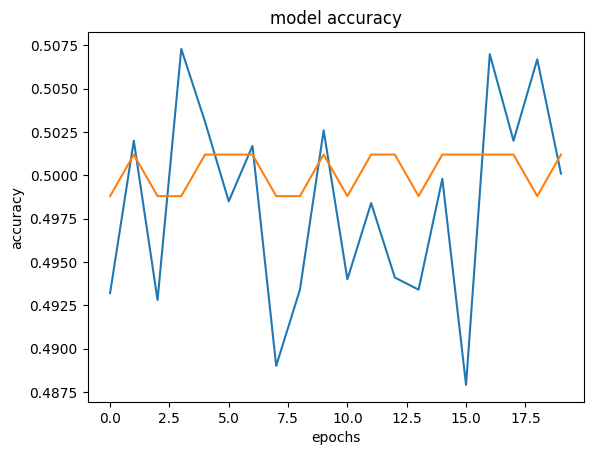

In [54]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")

In [56]:
pred_results = model.predict(([inputs_test,queries_test]))

313/313 [==============================] - 1s 2ms/step


In [57]:
test_data[0][0]

['Mary',
 'moved',
 'to',
 'the',
 'bathroom',
 '.',
 'Sandra',
 'journeyed',
 'to',
 'the',
 'bedroom',
 '.']

In [58]:
story=' '.join(word for word in train_data[23][0])

In [59]:
story

'Daniel got the apple there . John picked up the football there . Daniel left the apple . Daniel moved to the kitchen . Sandra went back to the bathroom . Sandra grabbed the apple there . John dropped the football . John got the football there . Sandra put down the apple . Sandra grabbed the apple there . Daniel travelled to the hallway . Sandra left the apple .'

In [60]:
query=' '.join(word for word in train_data[23][1])

In [61]:
query

'Is Daniel in the office ?'

In [62]:
test_data[23][2]

'no'

In [63]:
val_max=np.argmax(pred_results[23])
for key ,val in tokenizer.word_index.items():
    if val==val_max:
        k=key
print("predicted answer is",k)
print("probability of certainity",pred_results[23][val_max])

predicted answer is yes
probability of certainity 0.5077539
